# HOW TO obtain data from ESO catalogues

The ESO catalogue facility provides access to the collection of data that were produced by PIs of ESO programmes and then integrated into the ESO science archive through the Phase 3 process. The full list of available cataolgues could be found [here](https://www.eso.org/qi/).

To access the data you can use the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` TAP Service. The module `archive_catalogues` provides some simple `python` wrapper around this. For more details please see the [ESOAsg documentation](https://esoasg.readthedocs.io/en/latest/)

In [1]:
from ESOAsg.ancillary import astro
from ESOAsg import archive_catalogues
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Choose the catalogue you want to query

To begin, you need to know which catalogue you are interested to query. If in doubt, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (and all their versions) using:
```python
archive_catalogues.all_catalogues_info(all_versions=True)
```
Note that the column `last_version` highlights with `False` and obsolte catalogue for which a newer version is present. 

It is however possible to remove these obsolete versions by setting:
```python
all_version=False # i.e. the default behavior
```

In [3]:
all_catalogues = archive_catalogues.catalogues_info(all_versions=False)

Now `all_catalogues` contains information on all the latest versions of the catalogues currently present at ESO:

In [4]:
all_catalogues['collection', 'table_name', 'title', 'version'][35:40].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,title,version
VIDEO,video_er3_zyjhks_XMM_catMetaData_fits_V3,VISTA Deep Extragalactic Observations Survey (VIDEO) - XMM field,3
VIKING,viking_er5_zyjj_1j_2hks_catMetaData_fits_V4,VISTA Kilo-degree Infrared Galaxy Survey (VIKING),4
VIPERS,VIPERS_SPECTRO_PDR2_ESO_fits_V1,VIPERS - VIMOS Public Extragalactic Redshift Survey,1
VMC,vmc_dr5_mPhotJ_V4,VISTA Magellanic Survey: Multi-Epoch J-Band Photometry,4
VMC,vmc_dr5_mPhotKs_V4,VISTA Magellanic Survey: Multi-Epoch Ks-Band Photometry,4


## Get a catalogue
In the following we will consider the [`VIKING version 4`](https://www.eso.org/qi/catalog/show/320) catalogue as an example:
```python
collection = 'VIKING'
table_viking = 'viking_er5_zyjj_1j_2hks_catMetaData_fits_V4'
```
By adding the condition `collections='VIKING'` it is possible to limit the table to the `VIKING` related catalogues only:

In [5]:
viking_catalogue = archive_catalogues.catalogues_info(all_versions=False, collections='VIKING')
viking_catalogue['table_name', 'version', 'last_version', 'RA_id', 'target_table'].show_in_notebook(display_length=10)

idx,table_name,version,last_version,RA_id,target_table
0,viking_er5_zyjj_1j_2hks_catMetaData_fits_V4,4,True,RA2000,


This allows to extract information such as `table_name` and `acknowledgment` in a simpler way: 

In [6]:
table_viking = viking_catalogue['table_name'].data[0]
acknowledgment_viking = viking_catalogue['acknowledgment'].data[0]
print('The name of the table is: {}. \nThe corresponding acknowledgment is:\n{}.'.format(
    table_viking, acknowledgment_viking))

The name of the table is: viking_er5_zyjj_1j_2hks_catMetaData_fits_V4. 
The corresponding acknowledgment is:
Please include the following acknowledgment in any published material that makes use of this data products: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories under programme ID(s) 179.A-2004(M).


You can glance the content of a catalogue by checking the name of the columns present in the associated list of collections (or list of tables):
```python
archive_catalogues.columns_info(collections='VIKING')
```

In [7]:
columns_viking = archive_catalogues.columns_info(collections='VIKING')
columns_viking[0:6].show_in_notebook(show_row_index=False, display_length=6)

table_name,column_name,ucd,datatype,description,unit
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,IAUNAME,meta.id,CHAR,IAU Name (not unique),
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,SOURCEID,meta.id;meta.main,BIGINT,UID of this merged detection as assigned by merge algorithm,
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,CUEVENTID,meta.bib,INTEGER,UID of curation event giving rise to this record,
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,FRAMESETID,meta.bib,BIGINT,UID of the set of frames that this merged source comes from,
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,RA2000,pos.eq.ra;meta.main,DOUBLE,Celestial Right Ascension,Degrees
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,DEC2000,pos.eq.dec;meta.main,DOUBLE,Celestial Declination,Degrees


Once you decided which is your favourite catalogue, you can get it using:
```python
archive_catalogues.get_catalogues(tables=table_name)
```
At the moment with limit the query to only 2 entries `VIKING` (i.e. we set `maxrec=2`):

In [8]:
VIKING = archive_catalogues.get_catalogues(tables=table_viking, maxrec=2)

[INFO]    :: The query to viking_er5_zyjj_1j_2hks_catMetaData_fits_V4 returned 2 entries (with a limit set to maxrec=2)


The result is thus stored in an `astropy.table`:

In [9]:
VIKING['SOURCEID', 'RA2000', 'DEC2000', 'ZAPERMAG3', 'JAPERMAG3', 'KSAPERMAG3'].show_in_notebook(show_row_index=False, display_length=2)

SOURCEID,RA2000,DEC2000,ZAPERMAG3,JAPERMAG3,KSAPERMAG3
,deg,deg,mag,mag,mag
601300524512,359.58446616230106,-34.149885693105354,20.971756,--,--
601300524513,359.58287244613047,-34.33604898202672,21.508678,--,--


## Explore the data

Now the `VIKING V4` catalogue is ready to be explored. As an example, we queried a larger fraction of the catalogue to show the color-color diagram for stars (in blue) and extended sources (red). 

Note that, to speed up the process, we queried the table for only the columns we are interested in, i.e. 'MERGEDCLASS', 'ZAPERMAG3', 'JAPERMAG3', and 'KSAPERMAG3'. In addition we also opted for an `asynchronous` query.

[INFO]    :: The query to the tap_service is in the status: EXECUTING
[INFO]    :: The query to the tap_service is in the status: COMPLETED
[INFO]    :: The query to viking_er5_zyjj_1j_2hks_catMetaData_fits_V4 returned 20000 entries (with a limit set to maxrec=20000)


<IPython.core.display.Javascript object>


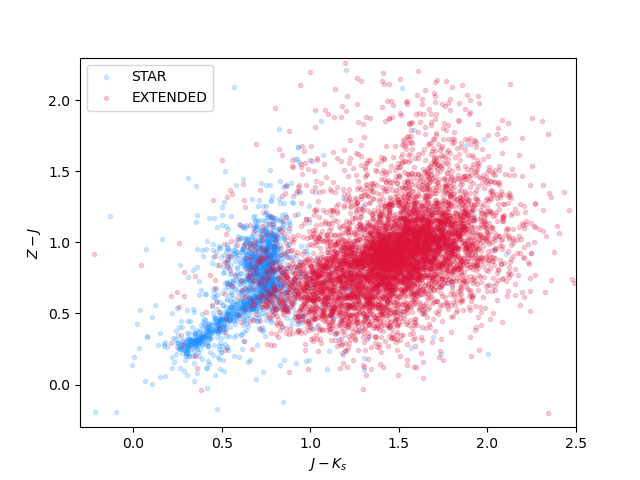

In [10]:
selected_columns = ['MERGEDCLASS', 'ZAPERMAG3', 'JAPERMAG3', 'KSAPERMAG3']

VIKING = archive_catalogues.get_catalogues(tables=table_viking, columns=selected_columns, maxrec=20000,
                                          type_of_query='async')

CLASS_STAR = VIKING['MERGEDCLASS'].data
JK = VIKING['JAPERMAG3'].data-VIKING['KSAPERMAG3'].data
ZJ = VIKING['ZAPERMAG3'].data-VIKING['JAPERMAG3'].data

plt.figure()
plt.xlim(-.3,2.5)
plt.ylim(-.3,2.3)
plt.scatter(JK[CLASS_STAR==-1],ZJ[CLASS_STAR==-1], label=r'STAR', c='dodgerblue', alpha=0.2, marker='.')
plt.scatter(JK[CLASS_STAR==1],ZJ[CLASS_STAR==1], label=r'EXTENDED', c='crimson', alpha=0.2, marker='.')
plt.xlabel(r'$J - K_s$')
plt.ylabel(r'$Z - J$')
plt.legend()
plt.show()
plt.savefig('viking.jpg', format='jpg', quality=99, bbox_inches='tight')